# Improving COVID-19 testing throughput using a variant of COMP

## Overview and Introduction

The purpose of this repository is to explore the feasability of using a variant of COMP to reduce the number of tests carried out to identify infected individuals in a population. This technique should be most applicable for when the proportion of infected individuals is small relative to the total population.


Before proceeding we state and adopt the following assumptions that constrain and motivate this investigation.
- **The test itself is the resource intense part of the process**: none of what follows is worthwhile doing if the onerous aspect of testing is the collection of test material from the members of a population, rather than the test itself. Indeed, we are motivated/ working under the context that the bottleneck of the entire testing apparatus is running the actual chemical/ biological test on the test material. This could for instance be motivated by a lack of reagents used in a test, or a lack of skilled manpower or laboratory space to conduct testing.
- **Its possible to combine test material**: test material (e.g. blood, swab etc.) of different members can be combined so that a group of members can be tested at the same time. As an illustration, a group blood test would involved running a test on a container containing a mixture of blood from a number of different members rather than a container with just one member's blood.
- **It is possible for test material from a single member to be distributed into a number of group tests**: sufficient material can be extracted from each member so that this material can be distributed into a number of group tests.
- **Group tests are sufficiently sensitive/ accurate**: the test is sensitive enough / there is significant enough material from each member in each group test such that if there is an infected member the group test will report back positive. We will relax this in later versions to account for false positives and false negatives during testing.
- **Saving in terms of the number of tests outweighs the overhead in management of the group testing**: we are also assuming that the overheads involved by conducting group testing is worthwhile for the saving in terms of the numbers of tests ran.

Our setup is as follows:
- Let $n$ be the population size
- Let $k$ be the number of infected individuals
- Let $m$ be the number of group tests we conduct
- Let $d$ be the number of tests each individuals 

Now consider the following variables:
- $x \in \{0,1\}^n$ is a k sparse (at most k nonzeros) binary vector indicating whether each individual is infected or not.
- $A \in \{0,1\}^{m \times n}$ is a binary matrix which matches group tests with individuals. Each column of A has a fixed number d of nonzeros which indicate which group tests an individuals test material is included in. Each row of A indicates the individuals involved in a group test.
- $\sigma(\cdot)$ is the unit step function which is applied elementwise to its vector argument.
- $y \in \{0,1\}^{m}$ is a binary vector indicating the outcome of each group test.

With these in mind then under the assumptions listed above we propose the following model: $$y = \sigma(Ax).$$ We consider $$x' = \sigma(A^T y - d)$$ as an estimate for $x$ and aim to show numerically that for an appropriatly chosen random matrix A and parameter regime that "$x' = x$ most of the time". From a theoertical perspective it can be shown without to much difficulty that this is true with high probability, and furthermore these algorithms can be extended to the noisy setting to model false positives and false negatives of a single test.

## Import necessary libraries

In [1]:
import numpy as np
import copy
import matplotlib.pyplot as plt
from timeit import default_timer as timer
from numpy import linalg as LA

## Supporting functions

In [554]:
def generate_latent(n,k):
    x = np.zeros(n)
    locs = np.random.permutation(n)[:k]
    x[locs] = 1
    return x

# Random Expander graph style sampling programs
def generate_group_tests(m,n,d):
    A = np.zeros((m,n))
    for i in range(n):
        locs = np.random.permutation(m)[:d]
        A[locs,i] = 1
    return A

def generate_group_tests2(m,n,d):
    A = np.zeros((m,n))
    alpha = int(np.floor(m/d))
    c = 0
    while c<n:
        perm = np.random.permutation(m)
        zeta = min(n-c, alpha)
        for j in range(zeta):
            locs = perm[j*d:(j+1)*d]
            A[locs,c] = 1
            c = c+1
    return A

# Method for classic group test (each test a disjoint set)
def generate_group_tests3(n,r):
    m = int(np.ceil(n/r))
    A = np.zeros((m,n))
    ind_start = 0
    ind_end = r
    exit=False
    i=0
    while exit==False:
        i+=1
        A[i,ind_start:ind_end] = np.ones(ind_end - ind_start)
        ind_start +=r
        ind_end = min(n, ind_end+r)
        if ind_start >= n:
            exit=True
    return A

def generate_group_tests4(m,n):
    r = int(np.ceil(n/m))
    A = np.zeros((m,n))
    ind_start = 0
    ind_end = r
    exit=False
    i=0
    while exit==False:
        A[i,ind_start:ind_end] = np.ones(ind_end - ind_start)
        ind_start +=r
        i+=1
        ind_end = min(n, ind_end+r)
        if ind_start >= n:
            exit=True
    return A

def sigma(z):
    w = copy.deepcopy(z)
    w[w>0] = 1
    w[w <=0] =0
    return w

def recover_latent(y, A, d, n):
    b = (d-1)*np.ones(n)
    x = sigma(np.transpose(A)@y - b)
    return x

def remove_negs(y,A,d,n):
    x_neg = np.ones(n)
    for i in range(m):
        if y[i] == 0:
            row = A[i,:]
            locs = np.where(row[row==1])[0]
            x_neg[locs] = 0
    return x_neg

def check_estimate(x, x_est, n):
    diff = np.abs(3*x - x_est)    
    tns = len(diff[diff==0])
    fps = len(diff[diff==1])
    tps = len(diff[diff==2])
    fns = len(diff[diff==3])
    return [tps, tns, fps, fns]

## Basic simulation to test feasability

In [457]:
# Setup parameter regime
n = 5*10**4
k = int(np.ceil(0.02*n)) # 2% of individuals infected
d = 10
m = int(np.ceil(n/3)) # 1/3 as many group tests as individuals

In [458]:
# Generate data
x = generate_latent(n,k)
A = generate_group_tests(m,n,d)
y = sigma(A@x)

In [459]:
# Try and recover latent (i.e., vector indicating the infected members of a population)
x_est = recover_latent(y, A, d, n)

In [460]:
# Analyze recovery
[tps, tns, fps, fns] = check_estimate(x, x_est, n)
print("True positives as percentage of positives: ", str.format('{0:.2f}', 100*tps/k), "%")
print("False negatives as percentage of positives: ", str.format('{0:.2f}', 100*fns/k), "%")
print("True negatives as percentage of negatives: ", str.format('{0:.2f}', 100*tns/(n-k)), "%")
print("False positives as percentage of negatives: ", str.format('{0:.2f}', 100*fps/(n-k)), "%")

True positives as percentage of positives:  100.00 %
False negatives as percentage of positives:  0.00 %
True negatives as percentage of negatives:  99.97 %
False positives as percentage of negatives:  0.03 %


## Simulation using April 29th Pillar 2 data

In [545]:
# Set parameters
N = 100
n = 19056
k = 1580
d = 4
m_range = np.array([1000,2000,3000,5000,7000,8000,10000,12000,14000,19000])

In [546]:
# Define variables
tps_count = np.zeros(len(m_range))
tns_count = np.zeros(len(m_range))
fps_count = np.zeros(len(m_range))
fns_count = np.zeros(len(m_range))

# Run experiments
for i in range(len(m_range)):
    m = m_range[i]
    print("Running trials with m =", str.format('{0:.0f}',m))
    # Run each parameter setting N times
    for j in range(N):
        # Generate data for a test
        x = generate_latent(n,k)
        A = generate_group_tests(m,n,d)
        y = sigma(A@x)
        # Attempt to recover latent
        x_est = recover_latent(y, A, d, n)
        # Check recovery
        [tps, tns, fps, fns] = check_estimate(x, x_est, n)
        tps_count[i] += tps
        tns_count[i] += tns
        fps_count[i] += fps
        fns_count[i] += fns
        if np.mod(j+1,20)==0 and j!=0:
            print(str.format('{0:.0f}',100*(j+1)/N), "% of tests completed")

tps_av = tps_count/N
tns_av = tns_count/N
fps_av = fps_count/N
fns_av = fns_count/N

Running trials with m = 1000
20 % of tests completed
40 % of tests completed
60 % of tests completed
80 % of tests completed
100 % of tests completed
Running trials with m = 2000
20 % of tests completed
40 % of tests completed
60 % of tests completed
80 % of tests completed
100 % of tests completed
Running trials with m = 3000
20 % of tests completed
40 % of tests completed
60 % of tests completed
80 % of tests completed
100 % of tests completed
Running trials with m = 5000
20 % of tests completed
40 % of tests completed
60 % of tests completed
80 % of tests completed
100 % of tests completed
Running trials with m = 7000
20 % of tests completed
40 % of tests completed
60 % of tests completed
80 % of tests completed
100 % of tests completed
Running trials with m = 8000
20 % of tests completed
40 % of tests completed
60 % of tests completed
80 % of tests completed
100 % of tests completed
Running trials with m = 10000
20 % of tests completed
40 % of tests completed
60 % of tests complete

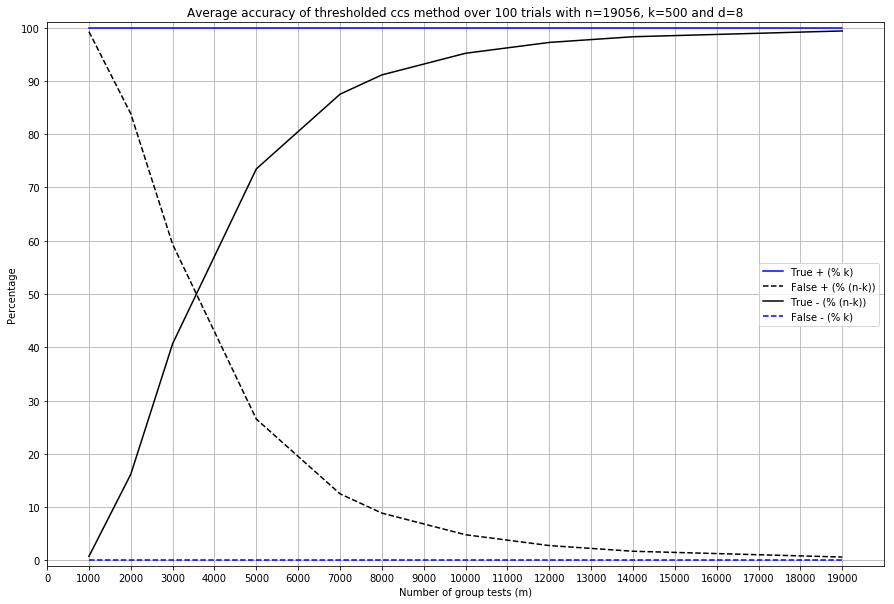

In [547]:
tps_plot = 100*tps_av/k
tns_plot = 100*tns_av/(n-k)
fps_plot = 100*fps_av/(n-k)
fns_plot = 100*fns_av/k

plt.figure(3)
plt.figure(figsize=(15,10))
plt.plot(m_range, tps_plot, 'b-', label="True + (% k)")
plt.plot(m_range, fps_plot, 'k--', label="False + (% (n-k))")
plt.plot(m_range, tns_plot, 'k-', label="True - (% (n-k))")
plt.plot(m_range, fns_plot, 'b--', label="False - (% k)")
plt.grid(True)
plt.title('Average accuracy of thresholded ccs method over 100 trials with n=19056, k=500 and d=4')
plt.xlabel('Number of group tests (m)')
plt.ylabel('Percentage')
plt.ylim(-1,101)
plt.xlim(0,20000)
plt.yticks(np.arange(0, 110, 10))
plt.xticks(np.arange(0, 20000, 1000))
plt.legend()
# Savedown plot
# plt.savefig('./plots/UK_pillar_2_sim_k_500.pdf', format='pdf', bbox_inches='tight')

In [548]:
# Compute reduction in number of tests required
print(m_range)
print(m_range + fps_av + tps_av)
print("Assuming 100% test accuracy then identification of infected individuals possible with just", str.format('{0:.0f}',np.min(m_range + fps_av + tps_av)), "tests.")
print("this implies testing output could be improved increased by a factor of", str.format('{0:.2f}',n/np.min(m_range + fps_av + tps_av)),".")

[ 19921.51  18230.4   14947.7   11215.63  10765.89  11133.37  12423.63
  14068.75  15882.26  20692.15]
Assuming 100% test accuracy then identification of infected individuals possible with just 10766 tests.
this implies testing output could be improved increased by a factor of 1.77 .


### Comparison with straight Group + Individual

In [550]:
m_g = 8000
G=generate_group_tests4(m_g,n)
x = generate_latent(n,1580)
y = sigma(G@x)
locs = np.where(y==1)
print(sum(sum(G[locs[0],:])))
tot = m_g + sum(sum(G[locs[0],:]))
print("Assuming 100% test accuracy then identification of infected individuals based standard group testing with the same number of group tests is", str.format('{0:.0f}',tot), "tests.")

4350.0
Assuming 100% test accuracy then identification of infected individuals based standard group testing with the same number of group tests is 12350 tests.


### Enhancing COMP by removing negatives

In [557]:
# Generate data
# Generate data
k_test = 1580
m_test = 8000
x = generate_latent(n,k_test)
A = generate_group_tests(m_test,n,d)
y = sigma(A@x)
print(len(y))
x_est = recover_latent(y, A, d, n)
x_neg = remove_negs(y,A,d,n)
x_comb = np.multiply(x_est,x_neg)

[tps, tns, fps, fns] = check_estimate(x, x_est, n)
print("Result for standard COMP approach")
print("True positives as percentage of positives: ", str.format('{0:.2f}', 100*tps/k), "%")
print("False negatives as percentage of positives: ", str.format('{0:.2f}', 100*fns/k), "%")
print("True negatives as percentage of negatives: ", str.format('{0:.2f}', 100*tns/(n-k)), "%")
print("False positives as percentage of negatives: ", str.format('{0:.2f}', 100*fps/(n-k)), "%")

[tps, tns, fps, fns] = check_estimate(x, x_neg, n)
print("Result just from removing negatives")
print("True positives as percentage of positives: ", str.format('{0:.2f}', 100*tps/k), "%")
print("False negatives as percentage of positives: ", str.format('{0:.2f}', 100*fns/k), "%")
print("True negatives as percentage of negatives: ", str.format('{0:.2f}', 100*tns/(n-k)), "%")
print("False positives as percentage of negatives: ", str.format('{0:.2f}', 100*fps/(n-k)), "%")

[tps, tns, fps, fns] = check_estimate(x, x_comb, n)
print("Result from combining:")
print("True positives as percentage of positives: ", str.format('{0:.2f}', 100*tps/k), "%")
print("False negatives as percentage of positives: ", str.format('{0:.2f}', 100*fns/k), "%")
print("True negatives as percentage of negatives: ", str.format('{0:.2f}', 100*tns/(n-k)), "%")
print("False positives as percentage of negatives: ", str.format('{0:.2f}', 100*fps/(n-k)), "%")

8000


IndexError: index 8000 is out of bounds for axis 0 with size 8000

## Simulation based on April 29th Pillar 2 data but with lower k

In [465]:
# Set parameters
N = 100
n = 19056
k = 500
d = 8
m_range = np.array([1000,2000,3000,5000,7000,8000,10000,12000,14000,19000])

In [467]:
# Define variables
tps_count = np.zeros(len(m_range))
tns_count = np.zeros(len(m_range))
fps_count = np.zeros(len(m_range))
fns_count = np.zeros(len(m_range))

# Run experiments
for i in range(len(m_range)):
    m = m_range[i]
    print("Running trials with m =", str.format('{0:.0f}',m))
    # Run each parameter setting N times
    for j in range(N):
        # Generate data for a test
        x = generate_latent(n,k)
        A = generate_group_tests(m,n,d)
        y = sigma(A@x)
        # Attempt to recover latent
        x_est = recover_latent(y, A, d, n)
        # Check recovery
        [tps, tns, fps, fns] = check_estimate(x, x_est, n)
        tps_count[i] += tps
        tns_count[i] += tns
        fps_count[i] += fps
        fns_count[i] += fns
        if np.mod(j+1,20)==0 and j!=0:
            print(str.format('{0:.0f}',100*(j+1)/N), "% of tests completed")

tps_av = tps_count/N
tns_av = tns_count/N
fps_av = fps_count/N
fns_av = fns_count/N

Running trials with m = 1000
20 % of tests completed
40 % of tests completed
60 % of tests completed
80 % of tests completed
100 % of tests completed
Running trials with m = 2000
20 % of tests completed
40 % of tests completed
60 % of tests completed
80 % of tests completed
100 % of tests completed
Running trials with m = 3000
20 % of tests completed
40 % of tests completed
60 % of tests completed
80 % of tests completed
100 % of tests completed
Running trials with m = 5000
20 % of tests completed
40 % of tests completed
60 % of tests completed
80 % of tests completed
100 % of tests completed
Running trials with m = 7000
20 % of tests completed
40 % of tests completed
60 % of tests completed
80 % of tests completed
100 % of tests completed
Running trials with m = 8000
20 % of tests completed
40 % of tests completed
60 % of tests completed
80 % of tests completed
100 % of tests completed
Running trials with m = 10000
20 % of tests completed
40 % of tests completed
60 % of tests complete

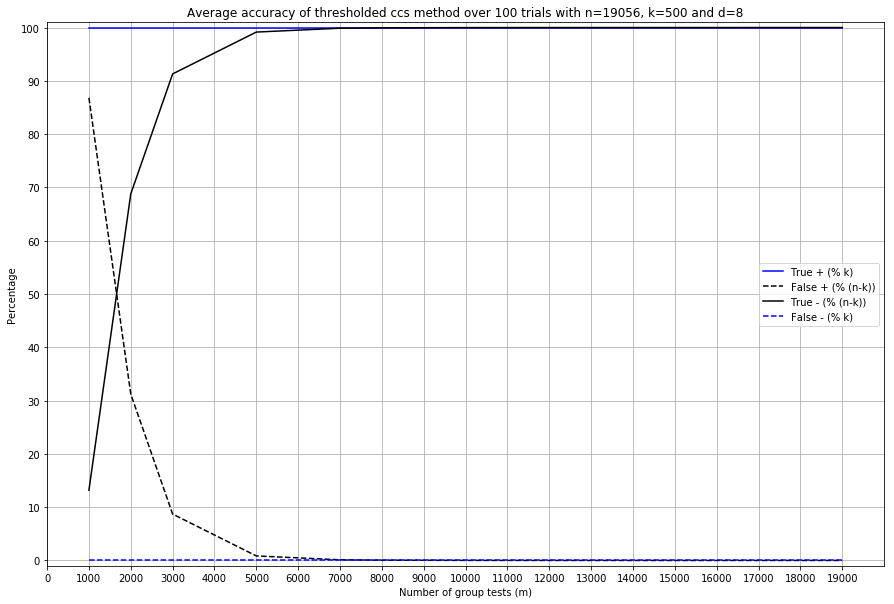

In [468]:
tps_plot = 100*tps_av/k
tns_plot = 100*tns_av/(n-k)
fps_plot = 100*fps_av/(n-k)
fns_plot = 100*fns_av/k

plt.figure(3)
plt.figure(figsize=(15,10))
plt.plot(m_range, tps_plot, 'b-', label="True + (% k)")
plt.plot(m_range, fps_plot, 'k--', label="False + (% (n-k))")
plt.plot(m_range, tns_plot, 'k-', label="True - (% (n-k))")
plt.plot(m_range, fns_plot, 'b--', label="False - (% k)")
plt.grid(True)
plt.title('Average accuracy of thresholded ccs method over 100 trials with n=19056, k=500 and d=8')
plt.xlabel('Number of group tests (m)')
plt.ylabel('Percentage')
plt.ylim(-1,101)
plt.xlim(0,20000)
plt.yticks(np.arange(0, 110, 10))
plt.xticks(np.arange(0, 20000, 1000))
plt.legend()
# Savedown plot
# plt.savefig('./plots/UK_pillar_2_sim_k_500.pdf', format='pdf', bbox_inches='tight')

In [469]:
# Compute reduction in number of tests required
# print(m_range + fps_av + tps_av)
print("Assuming 100% test accuracy then identification of infected individuals possible with just", str.format('{0:.0f}',np.min(m_range + fps_av + tps_av)), "tests.")
print("this implies testing output could be improved increased by a factor of", str.format('{0:.2f}',n/np.min(m_range + fps_av + tps_av)),".") 

Assuming 100% test accuracy then identification of infected individuals possible with just 5115 tests.
this implies testing output could be improved increased by a factor of 3.73 .
